In [1]:
import numpy, pylab

d = numpy.loadtxt('hmi.txt')


m1v = []
m2v = []
mv = []
vv = []

i = 0
j = 0
ms = []
ss = []
ic = []
for x in d:
    if i==17:
        i = 0
        j += 1
        ms = []
        ss = []
        ic = []
    
    inc = x[0]
    m = x[1]
    fl = x[2]
    
    m1 = x[3]
    m2 = x[4]
    
    s1 = x[5]
    s2 = x[6]
    
    ms.append(m)
    ss.append(s1)
    ic.append(inc)
    i+=1
    
    if i == 17:
        ic = numpy.array(ic)
        ms = numpy.array(ms)
        ss = numpy.array(ss)
        w = numpy.sin(ic) * ss**3.0
        w /= w.sum()
        
        mave = (ms*w).sum()
        vc = (mave **3.0) * (ss[0] / s2) ** 3.0
        
        m1v.append(m1)
        m2v.append(m2)
        mv.append(mave)
        vv.append(vc)
        
        print m1, m1, mave, vc

20.0 20.0 0.9543591651486351 1.029912801933613
20.0 20.0 0.944388619137139 0.9734861449657539
20.0 20.0 0.9441153217229858 0.9489304190258839
20.0 20.0 0.9392375276765775 0.9394922264744439
20.0 20.0 0.9428551243492629 0.9494775689147122
20.0 20.0 0.9456477334601124 0.9330673051129819
20.0 20.0 0.9410915269984835 0.9033822130249817
20.0 20.0 0.9351394314826211 0.8714685029396915
20.0 20.0 0.9246572776315496 0.8373536246413732
20.0 20.0 0.9147943204969989 0.8062203045953541
25.0 25.0 0.9252385098549539 0.9160533042148459
25.0 25.0 0.9209608130566249 0.9039562967377733
25.0 25.0 0.9216756679865272 0.8803427087488462
25.0 25.0 0.9246851062183664 0.9015135531509039
25.0 25.0 0.9227828175519999 0.8928984152953433
25.0 25.0 0.9307242392118501 0.9039398814148233
25.0 25.0 0.9336241611048254 0.893946631727147
25.0 25.0 0.9257202167048196 0.8623271294427451
25.0 25.0 0.921522036822232 0.8339381528454445
25.0 25.0 0.9173389475890154 0.8198523564801812
30.0 30.0 0.9124168646657894 0.8993674027931

(0.01, 1)

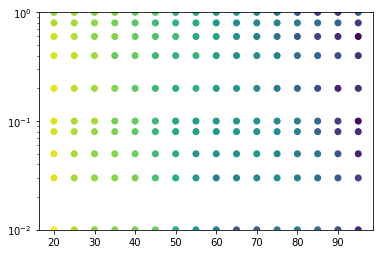

In [2]:
pylab.scatter(m1v, m2v, c=mv)
pylab.yscale('log')
pylab.ylim(.01, 1)

(0.01, 1)

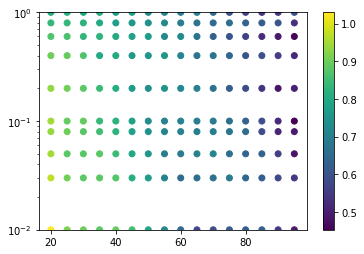

In [3]:
pylab.scatter(m1v, m2v, c=vv)
pylab.yscale('log')
pylab.colorbar()
pylab.ylim(.01, 1)

In [4]:
from scipy.interpolate import interp2d

vcinterp = interp2d(m1v, m2v, vv)

In [5]:
import glob, h5py
fnames = glob.glob('injs/*.hdf')

n = 0 
n2 = 0

m1 = []
m2 = []
dist = []
found = []
missed = []
ifar = []

for fname in fnames:
    f = h5py.File(fname, 'r')
    n += len(f['found/ifar_exc'])
    n2 += len(f['missed/after_vetoes'])
    
    m1.append(f['injections/mass1'][:])
    m2.append(f['injections/mass2'][:])
    dist.append(f['injections/distance'][:])
    ifar.append(f['found/ifar_exc'][:])
    
    fo = f['found/injection_index'][:]
    fo2 = numpy.zeros(len(f['injections/mass1']), dtype=bool)
    fo2[fo] = True
    
    mo = f['missed/after_vetoes'][:]
    mo2 = numpy.zeros(len(f['injections/mass1']), dtype=bool)
    mo2[mo] = True

    
    found.append(fo2)
    missed.append(mo2)
    
print n, n2, n+n2
    
ifar = numpy.concatenate(ifar)
m1 = numpy.concatenate(m1)
m2 = numpy.concatenate(m2)
dist = numpy.concatenate(dist)
found = numpy.concatenate(found)
missed = numpy.concatenate(missed)

found[found] = (ifar > 100)
 
from pycbc.conversions import mchirp_from_mass1_mass2

mc = mchirp_from_mass1_mass2(m1, m2)

print missed.sum(), found.sum()
    
#pylab.scatter(m1, m2, s=.01)
#pylab.yscale('log')
#pylab.ylim(.01, 1)
#pylab.xscale('log')

42494 96982 139476
96982 35451


In [6]:
from pycbc.sensitivity import volume_montecarlo, volume_to_distance_with_errors

nbin1 = 8
nbin2 = 19
m1e = numpy.logspace(numpy.log10(20), 2, nbin1+1)
m2e = numpy.logspace(-2, 0, nbin2+1)

mp1 = []
mp2 = []
dp = []
for i in range(nbin1):
    for j in range(nbin2):
        region = (m1 < m1e[i+1]) & (m1 >= m1e[i]) & (m2 < m2e[j+1]) & (m2 >= m2e[j])
        
        m1c = (m1e[i+1] + m1e[i]) / 2.0
        m2c = (m2e[j+1] + m2e[j]) / 2.0
        
        mp1.append(m1c) 
        mp2.append(m2c) 
        
        #print region.sum()
        fd = dist[found & region]
        md = dist[missed & region]

        fmc = mc[found & region]
        mmc = mc[missed & region]

        v, e = volume_montecarlo(fd, md, fmc, mmc, 'chirp_distance', 'uniform', 'chirp_distance')
        
        vf = vcinterp(m1c, m2c)
        v*= vf
        
        d, el, eh = volume_to_distance_with_errors(v, e)
        
        dp.append(d)
    

dp = numpy.array(dp).flatten()
mp1 = numpy.array(mp1)
mp2 = numpy.array(mp2)

In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean * 2.7   # height in inches
fig_size =  [fig_width,fig_height]
params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          #'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 200,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}
mpl.rcParams.update(params)

/home/ahnitz/projects/hmr/env/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


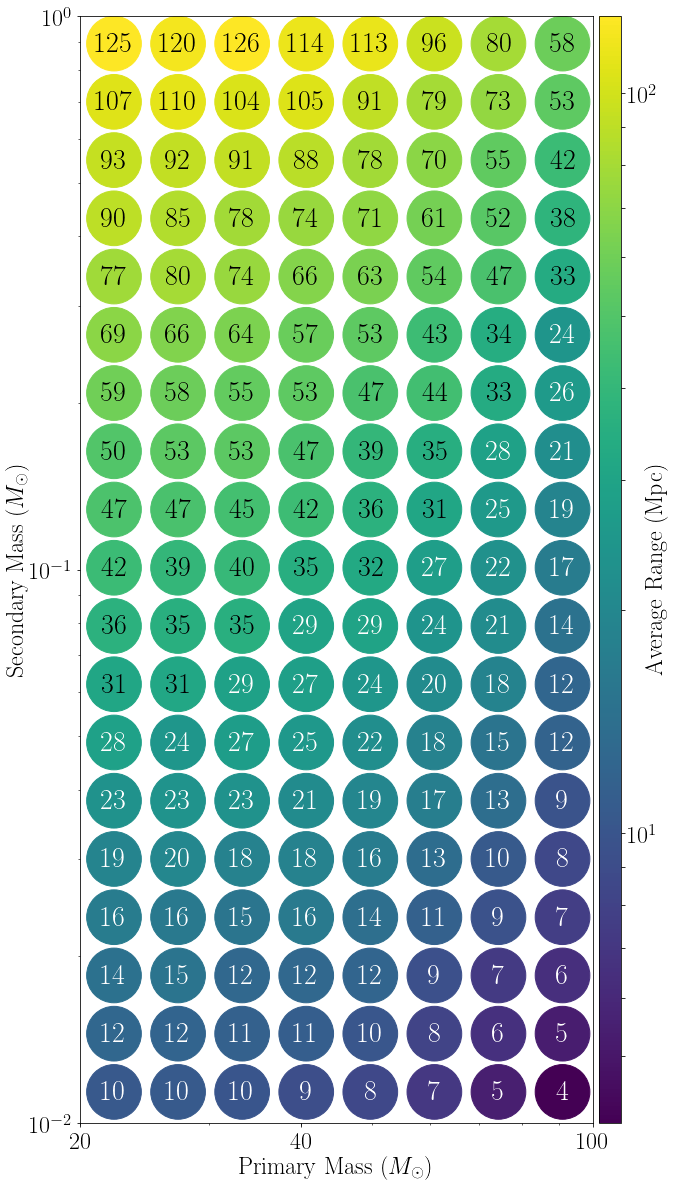

In [8]:
import matplotlib.colors as colors
import matplotlib.ticker
import numpy
from matplotlib.ticker import ScalarFormatter, NullFormatter

pylab.rc('text', usetex=True)
pylab.figure()
#pylab.figure(figsize=[4,7], dpi=400)
ax1 = pylab.gca()

for x, y, z in zip(mp1, mp2, dp):
    ax1.text(x, y, int(z), fontsize=28, color='black' if z > 30 else 'white',
               horizontalalignment='center',
            verticalalignment='center',)

ax1.set_ylim(.01, 1.0)
ax1.set_xlim(20, 100)
ax1.set_ylabel('Secondary Mass ($M_\\odot$)', labelpad=-1)
ax1.set_xlabel('Primary Mass ($M_\\odot$)')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xticks([20, 40, 100])
ax1.xaxis.set_major_formatter(ScalarFormatter())
ax1.xaxis.set_minor_formatter(NullFormatter())

p = ax1.scatter(mp1, mp2, c=dp, s=2990, norm=colors.LogNorm())
c = pylab.colorbar(p, aspect=50, pad=.01)
c.set_label('Average Range (Mpc)', labelpad=-14)

pylab.tight_layout()
pylab.savefig('sense.pdf')